# BAYa class Assignment 2023

In this assignment, your task will be to implement and analyze inference in the Probailistic linear discriminant analysis (PLDA) model. This model was described in the corresponding [slides from BAYa class](http://www.fit.vutbr.cz/study/courses/BAYa/public/slides/2-Graphical%20Models.pdf). You will accomplish this task by completing this Jupyter Notebook, which already comes with a code generating the training data and some plotting functions for presenting the results. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3, run Jupyter Notebook, and open this notebook downloaded from [BAYa_Assignment2023.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2023.ipynb). You can also find some inspiration and pieces of code to reuse in the other [Jupyter Notebooks provided for this class](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks).

The Notebook is organized as follows:
1. First comes a cell with a code of functions that will be later used for presenting the results and the learned models. Specifically, it contains code for plotting 2 dimensional multivariate Gaussian distributions, and plotting 2-dimensional data points. You can skip this cell first as the use of the functions will be demonstrated later.
2. Next comes a code that "handcrafts" some parameters of the PLDA model and implements the generative process assumed by the PLDA model. The code generates some artificial training data that you will use for PLDA model training. Please carefully read this code and the comments around it.
3. Through this notebook, there are cells with instructions to fill in your implementations around the PLDA model. There are also fields with other tasks to accomplish and questions to answer. 

**Do not edit the code in the following cell for generating and presenting the training data!**
$$
\let\DeclareMathOperator\newcommand
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\bbeta}{\boldsymbol{\beta}}
\DeclareMathOperator{\NN}{\mathbf{N}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\SSigma}{\boldsymbol{\Sigma}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\diff}{\mathop{}\!\mathrm{d}}
\DeclareMathOperator{\zz}{\mathbf{z}}
\DeclareMathOperator{\ZZ}{\mathbf{Z}}
\DeclareMathOperator{\XX}{\mathbf{X}}
\DeclareMathOperator{\xx}{\mathbf{x}}
\DeclareMathOperator{\YY}{\mathbf{Y}}
\DeclareMathOperator{\NormalGamma}{\mathcal{NG}}
\DeclareMathOperator{\Tr}{Tr}
$$

In [1]:
# Run this code! But there is no need to pay much attention to this cell at the first pass through the notebook

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps


def rand_gauss(n, mu, cov):
    """
    Sample n data points from 2D Gaussian distribution with mean mu and covariance cov
    """
    return np.atleast_2d(sps.multivariate_normal.rvs(mu, cov, n))

def logpdf_gauss(x, mu, cov):
    """
    Evaluation of the log probability density function for Gaussian with mean mu and covariance cov
    """
    return sps.multivariate_normal.logpdf(x, mu, cov)

def plot2dfun(f, limits, resolution, ax=None):
    """
    Greyscale plot of 2D Multivariate distributions.
    
    """
    if ax is None:
        ax = plt
    xmin, xmax, ymin, ymax = limits
    xlim = np.arange(ymin, ymax, (ymax - ymin) / float(resolution))
    ylim = np.arange(xmin, xmax, (xmax - xmin) / float(resolution))
    a, b = np.meshgrid(ylim, xlim)
    img = f(np.vstack([np.ravel(a), np.ravel(b)[::-1]]).T)
    img = (img - img.min()) /(img.max() - img.min()) # normalize to range 0.0 - 1.0
    img = img.reshape(a.shape+img.shape[1:])
    return ax.imshow(img, cmap='gray', aspect='auto', extent=(xmin, xmax, ymin, ymax))

   
def gellipse(mu, cov, n=100, *args, **kwargs):
    """
    Contour plot of 2D Multivariate Gaussian distribution.

    gellipse(mu, cov, n) plots ellipse given by mean vector MU and
    covariance matrix COV. Ellipse is plotted using N (default is 100)
    points. Additional parameters can specify various line types and
    properties. See description of matplotlib.pyplot.plot for more details.
    """
    if mu.shape != (2,) or cov.shape != (2, 2):
        raise RuntimeError('mu must be a two element vector and cov must be 2 x 2 matrix')

    d, v = np.linalg.eigh(4 * cov)
    d = np.diag(d)
    t = np.linspace(0, 2 * np.pi, n)
    x = v @ np.sign(d) @ np.sqrt(np.abs(d)) @ np.array([np.cos(t), np.sin(t)]) + mu[:,np.newaxis]
    return plt.plot(x[0], x[1], *args, **kwargs)


## PLDA generative process

A PLDA model is often used to model speaker embeddings in the speaker verification context.
Such embeddings are obtained by means of a neural network (i.e. ResNet, TDNN, etc.) which is trained for speaker classification.
The neural network transforms variable-length input speech utterances into some fixed-length low-dimensional (i.e. 512, 1024) vector representations (e.g. the embeddings are the output of a hidden layer of the neural network).

The PLDA model assumes the following generative process for the embeddings (our observations):



\begin{align}
{\mathbf{z}_s} &\sim \mathcal{N}(\mathbf{z}_s;\boldsymbol{\mu},\boldsymbol{\Sigma}_{ac})&& \text{for } s=1, \dots, S\\
{\mathbf{x}_{sn}} &\sim \mathcal{N}(\mathbf{x}_{sn};\mathbf{z}_{s},\boldsymbol{\Sigma}_{wc})&& \text{for } n=1, \dots, N_s\\
\end{align}



where $\mathbf{z}$ is the continuous latent random variable related to the distribution of speaker means, $\boldsymbol{\mu}$ is the global speaker mean, $\boldsymbol{\Sigma}_{ac}$ is the across-class (across-speaker) covariance matrix, $\mathbf{x}$ is the continuous random variable related to the distribution of per-speaker observations (per-speaker embeddings), $\mathbf{z}_s$ is the speaker-specific mean for speaker $s$, and $\boldsymbol{\Sigma}_{wc}$ is the within-class (within-speaker) covariance matrix, which is shared among (the same for) all speakers.


Therefore, we assume that $S$ speaker means were generated from a Gaussian distribution $\mathcal{N}(\mathbf{z}_s;\boldsymbol{\mu},\boldsymbol{\Sigma}_{ac})$, and then $N_s$ embeddings were generated for each of such speakers from the Gaussian distribution $\mathcal{N}(\mathbf{x}_{sn};\mathbf{z}_{s},\boldsymbol{\Sigma}_{wc})$. This process can also be visulized in the Bayesian Network shown below.

Obviously, this assumption is something we make up when defining our model, as the embeddings were generated by the neural network, and not by such PLDA model.


<div>
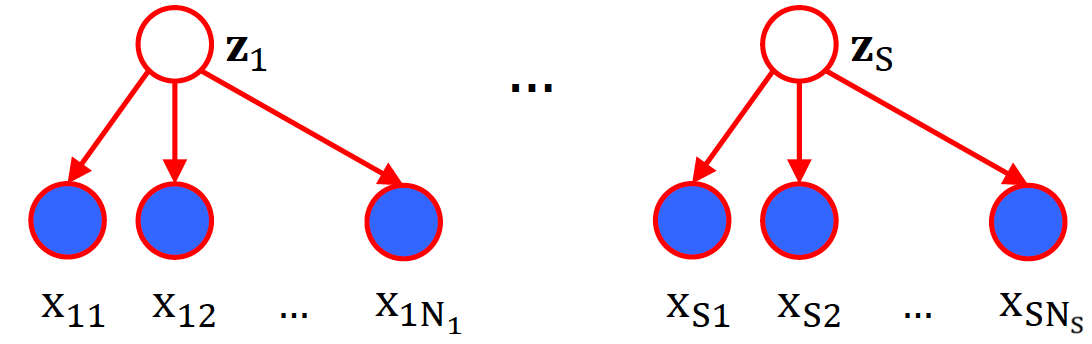
</div>

## Joint probability:

Given the definition of the PLDA model, we can now write the joint probability of all observed variables $\XX$ and latent variables $\ZZ$, where it should be straighforward to see that the joint probability factorizes per speaker (see the Bayesian network).

Let $\XX=[\XX_1,\XX_2,...,\XX_S]$, where $\XX_s = [\xx_{s1}, \xx_{s2}, \dots, \xx_{sN_s} ]$ contain the set of training observations of speaker $s$. Similarly, $\ZZ=[\zz_1,\zz_2,...,\zz_S]$.

Then, the joint probability is: 

$$P(\XX, \ZZ) 
= \prod_{s=1}^S p(\XX_s,\zz_s)
= \prod_{s=1}^S \left( p(\zz_s) \prod_{n=1}^{N_s} p(\xx_{sn}|\zz_s) \right)$$

$$\ln P(\XX, \ZZ) 
= \sum_{s=1}^S \ln p(\XX_s,\zz_s)
= \sum_{s=1}^S \ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s)$$



## Handcrafting the PLDA model

In order to generate some artificial training data, we will handcraft a *ground truth* PLDA model.
We will handcraft the global ground truth speaker mean $\boldsymbol\mu^{GT}$, and the covariance matrices $\boldsymbol{\Sigma}_{ac}^{GT}$ and $\boldsymbol{\Sigma}_{wc}^{GT}$. 
We will generate our training data using this PLDA model, and we hope to learn it back (or some close to it) during the PLDA model training. 
In order to be able to draw, visualize and interpret our models, we consider only a toy example with $D=2$ dimensional data.

The cell below handcrafts the PLDA model and plots its parameters. In the plot, the dot corresponds to the global mean, the blue elipse is the coutour plot of $\boldsymbol{\Sigma}_{ac}^{GT}$ and the red elipse is the countour plot of $\boldsymbol{\Sigma}_{wc}^{GT}$.


(-5.95685675343921, 7.954118920044291, -2.2998612816384827, 4.299970466102776)

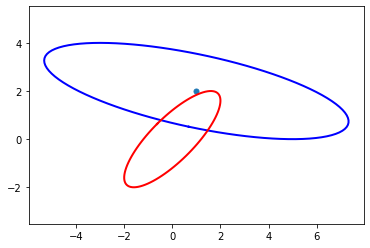

In [2]:
#Do not edit this code!
mu_gt =  np.array([1, 2]) #ground truth global mean
Sigma_wc_gt = np.array([[1, 0.8], #ground truth within class covariance
                     [0.8, 1]])

Sigma_ac_gt = np.array([[10, -2], #ground truth across class covariance
                     [-2, 1]])

plt.plot(mu_gt[0], mu_gt[1], '.', ms=10) #plotting the PLDA model
gellipse(mu_gt, Sigma_ac_gt, 100, 'b', lw=2)
gellipse(np.array([0,0]), Sigma_wc_gt, 100, 'r', lw=2) #for mere visualization purposes, we center the within-class covariance on the origin (0,0)
plt.axis('equal')


### Sampling training data
Once we have the global mean and the matrices $\boldsymbol\Sigma_{ac}^{GT}$ and $\boldsymbol\Sigma_{wc}^{GT}$, we can sample speakers and their corresponding embeddings.
We sample $S=10$ speaker means and then their corresponding embeddings, where we sample a different number of embeddings per speaker.

Besides sampling the data, the code below plots the countour of $\boldsymbol\Sigma_{ac}^{GT}$, the sampled speaker means, the countour of the per-speaker $\boldsymbol\Sigma_{wc}^{GT}$ and the per-speaker sampled embeddings.

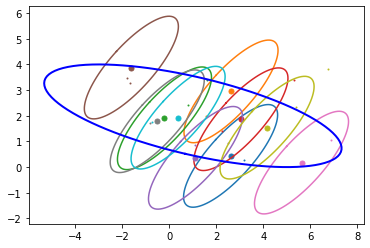

In [28]:
#Do not edit this code!
S = 10
#N = (np.arange(S)+1)**2 # (somewhat cryptic way of) assigning different N_s to each speaker, ranging from 1 to 10^2 
N = np.random.randint(1, 3, S) 
Z =  rand_gauss(S, mu_gt, Sigma_ac_gt) # training speaker xvector means
X = [] #Collection of all the X_s

# For each speaker
for ns, z in zip(N, Z):
    X_s = rand_gauss(ns, z, Sigma_wc_gt)
    X.append(X_s)
    p = plt.plot(X_s[:,0], X_s[:,1], '.', ms=2)
    c = p[0].get_color()
    plt.plot(z[0], z[1], '.', c=c, ms=10)
    gellipse(z, Sigma_wc_gt, 100, c=c)
gellipse(mu_gt, Sigma_ac_gt, 100, 'b', lw=2)

## Simple maximum-likelihood estimate of parameters

We can estimate the parameters of the PLDA model using the following formulas (which are the same as the ones used in the linear distriminant analysis or linear Gaussian classifier from SUR classes).

$N =  \sum_{s=1}^S N_s$

$\mmu = \frac{1}{N} \sum_{s=1}^S \sum_{n=1}^{N_s} \xx_{sn}$

$\mmu_s = \frac{1}{N_s} \sum_{n=1}^{N_s} \xx_{sn}$

$\SSigma_{ac} = \frac{1}{N} \sum_{s=1}^S N_s \left(\mmu_s-\mmu\right)\left(\mmu_s-\mmu\right)^T$

$\SSigma_{wc} = \frac{1}{N} \sum_{s=1}^S N_s \left(\frac{1}{N_s} \sum_{n=1}^{N_s} \left(\xx_{sn}-\mmu_s\right)\left(\xx_{sn}-\mmu_s\right)^T\right)$

### Task 1 

Implement such updates for the PLDA parameters and plot the obtained result, together with the ground truth PLDA model (plot the ground truth model for the sampled speakers with dotted lines for a better visualization).

(-5.968495767918077, 8.198538224100487, -2.3042122566821126, 4.391340942019011)

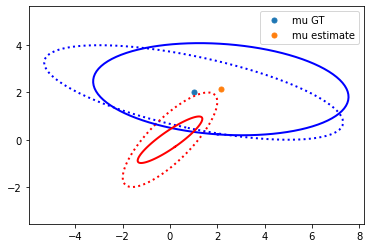

In [29]:
#Your implementation of the simple ML estimate of the parameters goes here

N_simple = np.sum(N)
X_sum_per_s = [np.sum(X_s, axis=0) for X_s in X]
mu_simple = np.sum(X_sum_per_s, axis=0) / N_simple
mu_s_simple = X_sum_per_s / N.reshape(-1, 1)
mu_s_minus_mu = mu_s_simple - mu_simple
Sigma_ac_simple = np.sum((mu_s_minus_mu.reshape(-1, 2, 1) @ mu_s_minus_mu.reshape(-1, 1, 2)) * N.reshape(-1, 1, 1), axis=0) / N_simple
X_minus_mu_s = [X_s - mu_s for X_s, mu_s in zip(X, mu_s_simple)]
Sigma_wc_simple = np.sum([(np.sum(X_s_minus_mu_s.reshape(-1, 2, 1) @ X_s_minus_mu_s.reshape(-1, 1, 2), axis=0) / N_s) * N_s for X_s_minus_mu_s, N_s in zip(X_minus_mu_s, N)], axis=0) / N_simple
#Sigma_wc_simple_2 = np.sum([np.sum(X_s_minus_mu_s.reshape(-1, 2, 1) @ X_s_minus_mu_s.reshape(-1, 1, 2), axis=0) for X_s_minus_mu_s, N_s in zip(X_minus_mu_s, N)], axis=0) / N_simple

plt.plot(mu_gt[0], mu_gt[1], '.', ms=10, label='mu GT')
gellipse(mu_gt, Sigma_ac_gt, 100, ':b', lw=2)
gellipse(np.array([0,0]), Sigma_wc_gt, 100, ':r', lw=2)
plt.plot(mu_simple[0], mu_simple[1], '.', ms=10, label='mu estimate')
gellipse(mu_simple, Sigma_ac_simple, 100, 'b', lw=2)
gellipse(np.array([0,0]), Sigma_wc_simple, 100, 'r', lw=2)
plt.legend()
plt.axis('equal')

# PLDA Expectation Maximization training

With EM, we can get better estimate of the parameters than the *naive* simple maximum-likelihood estimates.

Your first task here will be to derive some of the math related to the expectation-maximization updates for PLDA model training.
Below we provide the framework for such derivations.


## Summary of the EM algorithm

The EM algorithm makes use of the following formula to find the parameters that maximize the likelihood of the data:




$\ln p(\mathbf{\XX}|\boldsymbol{\eta}) = 
\underbrace{\sum_{\ZZ}q(\ZZ) \ln p(\XX,\ZZ)|\boldsymbol{\eta})}_{\mathcal{Q}(q(\ZZ),\eta)}
\underbrace{-\sum_{\ZZ}q(\ZZ) \ln q(\ZZ)}_{H(q(\ZZ))}
\underbrace{-\sum_{\ZZ} q(\ZZ) \ln \frac{p(\ZZ | \XX,\boldsymbol{\eta})}{q(\ZZ)}}_{D_{KL}(q(\ZZ)||p(\ZZ|\XX,\eta)}$

The steps for the EM algorithm are:
1. Initialize parameters of the model (e.g. randomly or to constant values).
2. E-step, set $q(\ZZ):=p(\ZZ|\XX,\eta)$, to make the kullback-Lieber divergence 0
3. M-step, having fixed $q(\ZZ)$, optimize the parameters of the PLDA model to maximize the auxiliary function $\mathcal{Q}$ (and maximize therefore the likelihood of the data)





## E-step
In the E-step, we need to set $q(\ZZ):=p(\ZZ|\XX,\eta)$. 
By looking at the Bayesian network we can see that the posterior distribution of the latent variable  factorizes as $p(\ZZ|\XX,\eta)= \prod_s p(\mathbf{z}_s|\mathbf{X}_s,\eta)$.  Therefore $q(\ZZ)=\prod_s q(\zz_s)$ where we set $ q(\zz_s):=  p(\mathbf{z}_s|\mathbf{X}_s,\eta)$, which can be calculated as:


$$ p(\zz_s | \XX_s, \eta) 
=  \mathcal{N}(\zz_s;\mmu_s,\SSigma_s)$$ 

$$ \mmu_s = \SSigma_s \left(\SSigma_{ac}^{-1}\mmu + \SSigma_{wc}^{-1} \sum_{n=1}^{N_s}\xx_{sn}\right)  \hspace{2cm} \SSigma_s = \left(\SSigma_{ac}^{-1} + N_s \SSigma_{wc}^{-1} \right)^{-1}
$$


### Task 2: 
Complete the derivations of the E-step to obtain such update, start from the expression given below (but check the tips given after it).

$$
\begin{align}
\ln p(\zz_s | \XX_s, \eta) 
&= \ln p(\XX_s,\zz_s) + const. \\
&= \ln \left[ p(\zz_s) \prod_{n=1}^{N_s} p(\xx_{sn}|\zz_s) \right] + const. \\
&= \ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s) + const. \\
&= \ln \mathcal{N}(\zz_s;\mmu,\SSigma_{ac}) + \sum_{n=1}^{N_s} \ln \mathcal{N}(\xx_{sn}; \zz_s, \SSigma_{wc}) + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} \left( -\frac{1}{2} \xx_{sn}^T \SSigma_{wc}^{-1} \xx_{sn} + \xx_{sn}^T \SSigma_{wc}^{-1} \zz_s \right) + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} -\frac{1}{2} \xx_{sn}^T \SSigma_{wc}^{-1} \xx_{sn} + \sum_{n=1}^{N_s} \xx_{sn}^T \SSigma_{wc}^{-1} \zz_s + const. \\
&= -\frac{1}{2} \zz_s^T \SSigma_{ac}^{-1} \zz_s + \zz_s^T \SSigma_{ac}^{-1} \mmu + \sum_{n=1}^{N_s} \xx_{sn}^T \SSigma_{wc}^{-1} \zz_s + const. \\
&= TODO \\
&... \color{red}{write\ your\ derivations\ here}\\
\end{align}
$$

<div class="alert alert-block alert-info"><b>Tip: </b> To complete the derivation, it might be useful to understand what is the "completion of squares" method:


For any Gaussian distribution $\mathcal{N}(\mathbf{y};\mmu_o,\SSigma_o)$, the following holds: 

$$\ln \mathcal{N}(\mathbf{y};\mmu_o,\SSigma_o) = -\frac{D}{2} \ln (2\pi)-\frac{1}{2} \ln|\SSigma_o|-\frac{1}{2} (\mathbf{y}-\mmu_o)^T\SSigma_o^{-1}(\mathbf{y}-\mmu_o) = -\frac{1}{2} \mathbf{y}^T \SSigma_o^{-1} \mathbf{y} + \mathbf{y}^T \SSigma_o^{-1}\mmu_o + const.$$

where $const$ is a constant encompassing all terms independent of $\mathbf{y}$.
    
Therefore, if you obtain an expression in the form:

$$-\frac{1}{2} \mathbf{y}^T A \mathbf{y} + \mathbf{y}^T B$$

and you know that it corresponds to a valid probability distribution (up to the missing constant term) then it corresponds to the log of a (unnormalized) Gaussian distribution where $A$ and $B$ will be the terms $A=\SSigma_o^{-1}$ and $B=\SSigma_o^{-1}\mmu_o$. 
That is, it corresponds to $\ln \mathcal{N}(\mathbf{y};A^{-1}B, A^{-1})$.
</div>
    

    




## M-step
In the M-step, we keep $q(\mathbf{z}_s)$ fixed and we optimize the parameters of the model to maximize the auxliliary function.

### Task 3: 
Complete the derivation for the M-step.
**Explain** the different steps taken.
Start from the expression below, where the first steps are given, as well as the final solution:

$
\small
\begin{align}
\mathcal{Q} 
&= \int q(\ZZ) \ln p(\XX,\ZZ) \diff \ZZ \\
&= \int \dots \int \left(\prod_{s=1}^S q(\zz_s)\right) \sum_{s=1}^S \left(\ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s)\right) \diff\zz_1 \dots \diff \zz_S \\
\end{align}
$

Given the factorization over components (see slide 28 from [EM algorithm](https://www.fit.vutbr.cz/study/courses/BAYa/public/slides/3-EM%20algorithm.pdf)):

$
\small
\begin{align}
\mathcal{Q}&= \sum_{s=1}^S \int q(\zz_s) \left(\ln p(\zz_s) + \sum_{n=1}^{N_s} \ln p(\xx_{sn}|\zz_s)\right) \diff\zz_s\\
& ... \color{red}{write\ your\ derivations\ here\ to\ obtain:}\\
\end{align}
$

$
\scriptsize
\begin{align}
&\mathcal{Q} = -\frac{1}{2} \sum_{s=1}^S \left(
-\ln |\SSigma_{ac}^{-1}| + \Tr\left(\SSigma_s \SSigma_{ac}^{-1}\right) +\left(\mmu_s-\mmu\right)^T\SSigma_{ac}^{-1}\left(\mmu_s-\mmu\right) + \sum_{n=1}^{N_s}\left(-\ln |\SSigma_{wc}^{-1}| + \Tr\left(\SSigma_s\SSigma_{wc}^{-1}\right) +\left(\xx_{sn}-\mmu_s\right)^T\SSigma_{wc}^{-1}\left(\xx_{sn}-\mmu_s\right)\right)\right) + const. \\
\end{align}
$




<div class="alert alert-block alert-info"><b>Tip: </b> 
Given a probability density function $q(\mathbf{y})$, we define the expected values as:

$$ \E[\mathbf{y}] = \int q(\mathbf{y}) \mathbf{y} d\mathbf{y} $$

$$ \E[f(\mathbf{y})] = \int q(\mathbf{y}) f(\mathbf{y}) d\mathbf{y} $$

The expected values have (among others) the following properties:
   
$\E[X+Y]=\E[X]+\E[Y]$
    
$\E[aX]=a\E[X]$
    
For a Gaussian distribution $q(\mathbf{y})=\mathcal{N}(\mathbf{y};\mmu_o,\SSigma_o)$, it holds:

(1) $\E[\mathbf{y}] = \mmu_o$

(2) $\E[\mathbf{y}\mathbf{y}^T]=\SSigma_o+\mmu_o\mmu_o^T$

(3) $\E[\mathbf{y}^TA\mathbf{y}]=Tr(A\SSigma_o)+\mmu_o^TA\mmu_o$

where the operator $\Tr$ refers to $trace$, the sum of elements on the main diagonal of a matrix, which has the following properties:

$\Tr(A+B)=\Tr(A)+\Tr(B)$

$\Tr(ABC)=\Tr(CAB)=\Tr(BCA)$

In the derivations, you can make use of the results and properties defined above. If used, reference them in the explanations of the derivation.
    
Most of these $tricks$ and many others can be found in [The matrix cookbook]( https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf). If you use this book for any step of the derivations, reference the corresponding formula in the text. 
</div>

### Task 4
Now, using the expression of the auxiliary function $\mathcal{Q}$ provided above, derive the updates of $\mmu$ and $\SSigma_{ac}$ and $\SSigma_{wc}$.
Again, we provide the solution for these updates and you need to take the derivative of $\mathcal{Q}$ and set it equal to 0 to get to such solutions.

Recall, that even if you failed to complete the previous derivations you can proceed with this one.


$
\begin{align}
&\frac{\partial \mathcal{Q}}{\partial \mmu}
= \color{red}{write\ your\ derivations\ here}\\
&\implies \mmu := \frac{1}{S} \sum_{s=1}^S \mmu_s
\end{align}
$

$
\begin{align}
&\frac{\partial \mathcal{Q}}{\partial \SSigma_{ac}^{-1}}
=\color{red}{write\ your\ derivations\ here}\\
&\implies \SSigma_{ac} := \frac{1}{S} \sum_{s=1}^S \SSigma_s + \frac{1}{S} \sum_{s=1}^S \left(\mmu_s-\mmu\right)\left(\mmu_s-\mmu\right)^T
\end{align}
$

$
\begin{align}
&\frac{\partial \mathcal{Q}}{\partial \SSigma_{wc}^{-1}}
= \color{red}{write\ your\ derivations\ here}\\
&\implies \SSigma_{wc} := \frac{1}{\sum_{s=1}^S N_s} \sum_{s=1}^S N_s \left(\SSigma_s + \frac{1}{N_s} \sum_{n=1}^{N_s} \left(\xx_{sn}-\mmu_s\right)\left(\xx_{sn}-\mmu_s\right)^T\right)
\end{align}
$


<div class="alert alert-block alert-info"><b>Tip: </b> 
Note, that to obtain the updates of the covance matrices we are suggesting to take the derivative the auxiliary function $\mathcal{Q}$ with respect to the inverse of the covariance matrices. This results in somewhat simpler derivation of the updates. 
But (if you want to show off), you can start with the derivative with respect to the (non-inverse) covariance matrices, which leads to the same result.
    
</div>

### Task 5
Using the updates for the E and M step provided above, implement the EM algorithm for PLDA model training.

The cell below provides some initialization for the PLDA parameters.
Run the algorithm for 10 iterations and plot the obtained result, together with the ground truth PLDA model (plot the ground truth model for the sampled speakers with dotted lines for an better visualization).


****Note that we might modify this task so that the algorithm fits some specific form or function*

In [5]:
# Make use of the following variables
mu = np.array([0.0, 0.0]) #intial global mean
Sigma_ac = np.array([[1.0, 0.0], #initial across-class covariance matrix
                     [0.0, 1.0]])
Sigma_wc = np.array([[1.0, 0.0], #initial within-class covariance matrix
                     [0.0, 1.0]])


#Your implementation of the EM algorithm goes here

#E-step

#M-step






#Plotting instructions go here, reuse the function gellipse defined above





